In [1]:
colab = False
task_coloring = "coloring"
task_edges = "edges"
data_set_name = "Warblers"
task = task_coloring

In [2]:

if colab:
    # For google colab
    !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
    !pip install gputil
    !pip install psutil
    !pip install humanize
    import psutil
    import humanize
    import os
    import GPUtil as GPU
    GPUs = GPU.getGPUs()
    # XXX: only one GPU on Colab and isn’t guaranteed
    gpu = GPUs[0]
    def printm():
        process = psutil.Process(os.getpid())
        print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    printm()

In [3]:
if colab:
    # For google colab
    from google.colab import drive
    drive.mount('/content/gdrive')

In [4]:
if colab:
    # For google colab
    import sys
    sys.path.append('/content/gdrive/My Drive/Colab Notebooks/image_to_image/')

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import models
import data
import utils
from torchvision import transforms

cuda = torch.cuda.is_available()


In [6]:
import argparse

# Hyperparameters

parser = argparse.ArgumentParser()

parser.add_argument("--in_channels",      type=int,   default=3,   help="number of channels on input")
parser.add_argument("--out_channels",     type=int,   default=3,   help="number of channels on output")

parser.add_argument("--unet_depth",       type=int,   default=7,   
                    help="number of downsamplings on unet: image shape should equal [2^depth, 2^depth]")
parser.add_argument("--unet_out_f",       type=int,   default=64,  help="n of filters in the last conv layer of unet")
parser.add_argument("--unet_conv_kernel", type=int,   default=4,   help="kernel size on unet conv layers")
parser.add_argument("--unet_conv_stride", type=int,   default=2,   help="stride on unet conv layers")
parser.add_argument("--unet_conv_pad",    type=int,   default=1,   help="padding on unet conv layers")
parser.add_argument("--unet_dropout",     type=float, default=0.5, help="dropout rate on unet")
parser.add_argument("--unet_lrelu_slope", type=float, default=0.2, help="slope of leaky relu on unet")

parser.add_argument("--lr", type=float, default=0.0002, help='initial learning rate')
parser.add_argument("--beta1", type=float, default=0.5, help='first momentum term')
parser.add_argument("--beta2", type=float, default=0.999, help='second momentum term')
parser.add_argument('--lambda_L1', type=float, default=100.0, help='weight for L1 loss')

parser.add_argument('--n_epochs', type=int, default=200, help='number of epochs')

parser.add_argument('-f', '--file', help='Path for input file. First line should contain number of lines to search in')

hps = parser.parse_args()

In [7]:
def imshow(img, title=''):
    """Plot the image batch.
    """
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose( img.numpy(), (1, 2, 0)), cmap='gray')
    plt.show()

In [8]:
import matplotlib.pyplot as plt
from data_set import BirdEdgeDataset, BirdBWDataset, collate_fn

width = 256
height = 256
if task == task_edges:
    print("Edges task")

    """
    Fill edges task
    """
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomCrop(
            (height, width), pad_if_needed=True, padding_mode='constant'),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
    dataset = BirdEdgeDataset(f'./db/birds/{data_set_name}', transform=transform)
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=16, collate_fn=collate_fn)
elif task == task_coloring:
    print("coloring task")
    """
    Coloring task
    """

    # Only tranform the images to PILs and perform a random crop. The dataset will handle the rest.
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomCrop(
            (height, width), pad_if_needed=True, padding_mode='constant')
    ])

    dataset = BirdBWDataset(f'./db/birds/{data_set_name}', transform=transform)
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=16)


torch.Size([2, 3, 512, 512])torch.Size([2, 3, 512, 512])
coloring task


In [9]:
ImgToImg = models.ImageToImage(hps)

In [10]:
ImgToImg.D

Discriminator(
  (net): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [11]:
import os

if not colab:
    result_data_folder = f'./results/{task}/{data_set_name}'

    try:
        os.makedirs(result_data_folder)
    except FileExistsError as e:
        print('-'*21)
        print('Folder already exists')

if cuda:
    ImgToImg = nn.DataParallel(ImgToImg).cuda()


load = False

if cuda:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

if load:
    ImgToImg.load_state_dict(torch.load(f'./results/ImgToImg_birds_Yellow_black_edges.pth', map_location=device))
    print("loaded model")
    ImgToImg.to(device)
    ImgToImg.train()

---------------------
Folder already exists


In [13]:
import time
import torchvision

# Google colab version

if colab:

    for epoch in range(hps.n_epochs):

        for i, (x, y) in enumerate(loader):

            t = time.time()

            # Upsample
            x = u(x).cuda()
            y = u(y).cuda()
            ImgToImg.module.optimize_parameters(x, y)

            loss_G = ImgToImg.module.loss_G
            loss_D = ImgToImg.module.loss_D

            print('Batch: {}, iteration took {:.4f}, Loss_G: {}, Loss_D: {}'.format(i, time.time() - t, loss_G, loss_D))

            if (i + 1) % 1 == 0:
                # Save real input
                grid = torchvision.utils.make_grid(x)
                torchvision.utils.save_image(grid, '/content/gdrive/My Drive/Colab Notebooks/image_to_image/images1/dummy_test_{}_real_X.png'.format(epoch))

                # Save real output
                grid = torchvision.utils.make_grid(y)
                torchvision.utils.save_image(grid, '/content/gdrive/My Drive/Colab Notebooks//image_to_image/images1/dummy_test_{}_real_Y.png'.format(epoch))

                # Save fake output
                hat_y = ImgToImg.module.G(x)
                grid = torchvision.utils.make_grid(hat_y)
                torchvision.utils.save_image(grid, '/content/gdrive/My Drive/Colab Notebooks//image_to_image/images1/dummy_test_{}_fake_Y.png'.format(epoch))

# local CPU or GPU

else:
    
    for epoch in range(hps.n_epochs):

        for i, (x, y) in enumerate(loader):
            
            t = time.time()

            if cuda:
                x = x.cuda()
                y = y.cuda()
            
            ImgToImg.module.optimize_parameters(x, y)

            loss_G = ImgToImg.module.loss_G
            loss_D = ImgToImg.module.loss_D

            print('Batch: {}, iteration took {:.4f}, Loss_G: {}, Loss_D: {}'.format(i, time.time() - t, loss_G, loss_D))

            if (i + 1) % 1 == 0:
                # Save real input
                grid = torchvision.utils.make_grid(x)
                torchvision.utils.save_image(grid, f'{result_data_folder}/{epoch}_real_X.png')

                # Save real output
                grid = torchvision.utils.make_grid(y)
                torchvision.utils.save_image(grid, f'{result_data_folder}/{epoch}_real_Y.png')

                # Save fake output
                hat_y = ImgToImg.module.G(x)
                grid = torchvision.utils.make_grid(hat_y)
                torchvision.utils.save_image(grid, f'{result_data_folder}/{epoch}_fake_Y.png')

 0.03680311515927315
Batch: 45, iteration took 0.0554, Loss_G: 8.276217460632324, Loss_D: 0.05336102843284607
Batch: 46, iteration took 0.0568, Loss_G: 8.026031494140625, Loss_D: 0.04274632781744003
Batch: 47, iteration took 0.0638, Loss_G: 6.456905841827393, Loss_D: 0.21608619391918182
Batch: 48, iteration took 0.0598, Loss_G: 9.864452362060547, Loss_D: 0.09369432926177979
Batch: 49, iteration took 0.0738, Loss_G: 8.809989929199219, Loss_D: 0.501905083656311
Batch: 50, iteration took 0.0598, Loss_G: 8.45484733581543, Loss_D: 0.45991167426109314
Batch: 51, iteration took 0.0654, Loss_G: 7.743838310241699, Loss_D: 0.20853836834430695
Batch: 52, iteration took 0.0628, Loss_G: 8.071659088134766, Loss_D: 0.78591388463974
Batch: 53, iteration took 0.0597, Loss_G: 7.757187843322754, Loss_D: 0.18483084440231323
Batch: 54, iteration took 0.0588, Loss_G: 8.433425903320312, Loss_D: 0.17420276999473572
Batch: 55, iteration took 0.0688, Loss_G: 8.77181625366211, Loss_D: 0.07839763164520264
Batch: 

KeyboardInterrupt: 

In [83]:
save_folder = f'./results/{task}/{data_set_name}/model'

try:
    os.makedirs(save_folder)
except FileExistsError as e:
    print('-'*21)
    print('Folder already exists')

torch.save(ImgToImg.state_dict(), f'{save_folder}/model.pth')

torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 256, 256])


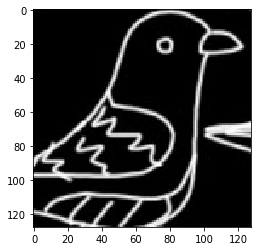

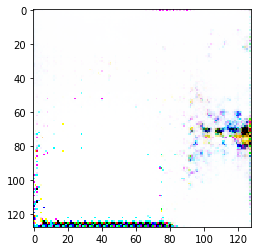

Image:


In [127]:
import data_set
import skimage.io as io
test_width = 128
test_height = 128
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(
        (test_width, test_height), pad_if_needed=True, padding_mode='constant'),
    transforms.ToTensor()
])

image = io.imread('./db/birds/dummy/bird_custom.jpg')
image = io.imread('./db/birds/dummy/bird_custom_2.jpg')
image = test_transform(image)
print(image.shape)
image = image.unsqueeze(0).cuda()
print(image.shape)
ImgToImg.eval()
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, collate_fn=data_set.collate_fn)
for x, y in test_loader:
    if (cuda):
        x = x.cuda()
        y = y.cuda()
   
    print(x.shape)
generated = ImgToImg.module.G(image)
plt.imshow(image[0].detach().cpu().permute(1, 2, 0).numpy())
plt.show()
plt.imshow(generated[0].detach().cpu().permute(1, 2, 0).numpy())
plt.show()
    
ImgToImg.train()
print("Image:")